In [80]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# Udacity DAND Data Visualisation Project

# Prosper Loan Dataset

## by Maria Latysheva

## Summary of the analysis and insights

In this paper I present the results of my analysis of the dataset of Prosper loans. Prosper is a peer-to-peer lending platform. Borrowers can find competitive rates for personal loans. Loans are funded by investors, not Prosper itself. The dataset contains 81 parameters and includes, after cleaning, around 77 thousand entries.


I focused my exploration on the following parameters:
- Borrower Rate, i.e. the interest rate on the loan offered by the lenders
- Loan Original Amount, i.e. the initial amount of the loan
- Loan Status (with a particular focus on `Defaulted` loans), i.e. whether the loan is completed, defaulted, current, etc.
- Prosper Rating, i.e. the rating of a borrower's reliability
- Income Range, i.e. how much a particular borrower earns 
- Debt-to-Income Ratio, i.e. how a borrower is overcredited

and explore the interactions between the variables and their possible effects on each other.

In my work I moved from univariate visualisations to bivariate visualisations and then to multivariate visualisations to explore the following questions:

- How is the Borrower Rate distributed and how is it affected by Loan Amount, Debt-to-Income Ratio and a borrower's Prosper Rating?

- What is the specifics of the Prosper loans in terms of the Loan Amount, Loan Status and Debt-to-Income Ratio?


In [39]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [40]:
loan_df = pd.read_csv('prosperLoanData.csv')

In [41]:
col_list = ['Term', 'LoanStatus', 'BorrowerRate', 'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)', 
            'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CreditScoreRangeLower',
            'CreditScoreRangeUpper', 'DebtToIncomeRatio', 'IncomeRange', 'LoanMonthsSinceOrigination', 
            'LoanOriginalAmount', 'LoanOriginationDate', 'MonthlyLoanPayment']

In [42]:
loan_df_clean = loan_df.copy()
loan_df_clean = loan_df_clean[col_list]

In [43]:
loan_df_clean = loan_df_clean.dropna()

In [44]:
# change Loan Origination Date to Loan Origination Year leaving only the year in which the loan was originated
# drop Loan Origination Date afterwards
loan_df_clean['LoanOriginationYear'] = loan_df_clean['LoanOriginationDate'].apply(lambda x: x.split('-')[0])
loan_df_clean = loan_df_clean.drop('LoanOriginationDate', axis = 1)

### Univariate Exploration

#### Are there any peculiarities in the distribution of the Borrower Rate?

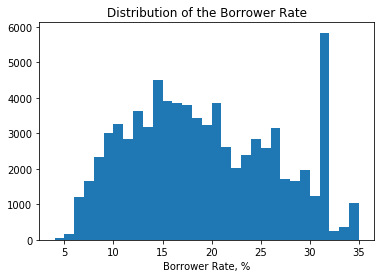

In [45]:
# plot a histogram with smaller bins to take a closer look at the abnormalities
bin_values = np.arange(0.04, 0.36, 0.01)
tick_props = np.arange(0.0, 0.36, 0.05)
tick_names = ['{:0.0f}'.format(v*100) for v in tick_props]
plt.xticks(tick_props, tick_names)
plt.hist(data = loan_df_clean, x = 'BorrowerRate', bins = bin_values);
plt.xlabel('Borrower Rate, %')
plt.title('Distribution of the Borrower Rate');


Instead of a close to normal distribution, we see a bimodal distribution with peaks at around 15% and 26% plus a very unusual peak around 32%. I will investigate this issue in the multivariate visualisations later.

In [46]:
# replace all Past Due statuses with the single 'Past Due' status 
loan_df_clean['LoanStatus'].replace(('Past Due (.*)'), 'Past Due', regex = True, inplace = True)

In [47]:
# define a function to convert a variable into an ordered categorical type

def type_to_ordered(dictionary):
    for var in dictionary:
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = dictionary[var])
        loan_df_clean[var] = loan_df_clean[var].astype(ordered_var)

In [48]:
# convert ProsperRating (Alpha), LoanStatus, and clarity into ordered categorical types
ordinal_var_dict = {'LoanStatus': ['Defaulted','Past Due','Chargedoff','Current',
                                   'FinalPaymentInProgress', 'Completed']}

In [49]:
type_to_ordered(ordinal_var_dict)

#### Can we see any strange observations in the distribution of the Loan Original Amount?
In this section I will explore the distribution of the Original Loan Amount. Since it is a numeric variable, I will use the `hist` function to plot a histogram.

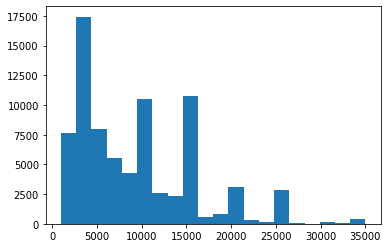

In [50]:
# plot a histogram showing the distribution of the Original Loan Amount
plt.hist(data = loan_df_clean, x = 'LoanOriginalAmount', bins = 20);

The distribution is highly skewed to the right with the peaks being on even numbers (10K, 15K, 20K, 25K), except for the peak at 4K loans.

In [51]:
listing_dict = {'ListingCategory (numeric)': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
type_to_ordered(listing_dict)

In [52]:
# identify entries with the Income Range being 'Not employed'
ind = loan_df_clean[(loan_df_clean.IncomeRange == 'Not employed')].index
ind

Int64Index([21386], dtype='int64')

In [53]:
# drop the only entry with the Income Range being Not employed
loan_df_clean = loan_df_clean.drop(ind)

In [54]:
# convert the Income Range into ordered type, with 'Not employed' being the lowest and $100,000+ being the heighest
incomeRange_dict = {'IncomeRange': ['$1-24,999', '$25,000-49,999', '$50,000-74,999', 
                                '$75,000-99,999', '$100,000+']}
type_to_ordered(incomeRange_dict)

#### Were the loans mostly provided to the borrower with high Prosper Rating or Prosper Score?

In this section I want to take a closer look at the distributions of the Prosper Rating and Prosper Score. Prosper Rating is a letter-based rating that goes from HR (the worst) up to AA (the best). Prosper Score is a numeric score that goes from 1 (the worst) to 11 (the best).

In [55]:
loan_df_clean['ProsperScore'] = loan_df_clean['ProsperScore'].astype(int)
loan_df_clean['ProsperScore'].unique()

array([ 7,  9,  4, 10,  2, 11,  8,  5,  3,  6,  1])

In [56]:
# convert the Prosper Rating into ordered type, with AA being the highest and HR being the lowest
prosper_dict = {'ProsperRating (Alpha)': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
               'ProsperScore': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
type_to_ordered(prosper_dict)

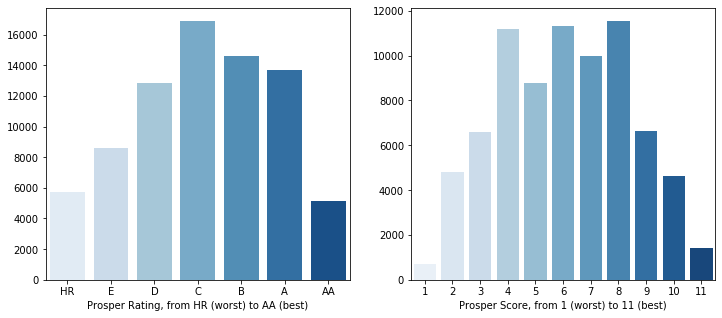

In [57]:
# left plot: distribution of Prosper Rating
plt.figure(figsize = [12, 5])
plt.subplot(1, 2, 1)
sb.countplot(data = loan_df_clean, x = 'ProsperRating (Alpha)', palette = 'Blues');
plt.xlabel('Prosper Rating, from HR (worst) to AA (best)')
plt.ylabel('')

# right plot: distribution of Prosper Score
plt.subplot(1, 2, 2)
sb.countplot(data = loan_df_clean, x = 'ProsperScore', palette = 'Blues');
plt.xlabel('Prosper Score, from 1 (worst) to 11 (best)')
plt.ylabel('');



We can see from the above plot that the majority of the loans had the average Prosper Rating of C (middle). And the majority of the distribution of Prosper Scores lie in the middle part, being from 4 to 8.

#### Were the loans mostly provided to well-being borrowers based on the Income Range parameter?

I will now take a closer look at the distributions of the Income Range and the Debt-to-Income Ratio.

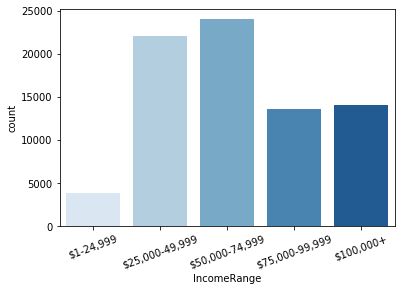

In [58]:
# plot the bar chart of the Income Range
sb.countplot(data = loan_df_clean, x = 'IncomeRange', palette = 'Blues');
plt.xticks(rotation = 20);

It may be seen from the above plot that the majority of the borrowers were earning income in the range from 25K to 75K, which is to be expected.

#### Are there any peculiarities in the distribution of the Debt-to-Income Ratio?

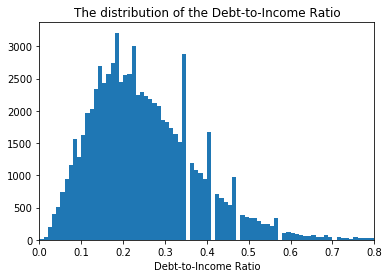

In [59]:
# plot the histogram of the Debt-to-Income Ratio
bins = np.arange(0, 1.3, 0.01)
plt.hist(data = loan_df_clean, x = 'DebtToIncomeRatio', bins = bins);
plt.xlabel('Debt-to-Income Ratio')
plt.title('The distribution of the Debt-to-Income Ratio')
plt.xlim(0, 0.8);

The disbribution is skewed to the right with some unusual peaks. The majority of loans were provided to borrowers with DIR not exceeding 0.3.

## Bivariate Exploration

In the Bivariate Section I investigated the relationships between pairs of variables in the Prosper dataset to try answering the following questions:

#### 1) Does the Borrower Rate depend on the Original Loan Amount?

This involves plotting two numeric variables.

#### 2) How does the Borrower Rate depend on the Prosper Rating?

This involves plotting one numeric and one categorical variable.

#### 1) Does the Borrower Rate depend on the the Loan Original Amount?

To see the correlating between these two variables, I plotted a scatter plot with a regression line and a heat map.

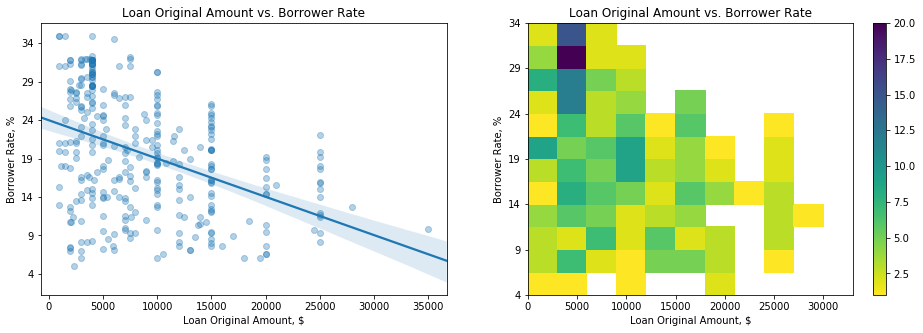

In [60]:
np.random.seed(2018)
sample = np.random.choice(loan_df_clean.shape[0], 500, replace = False)
loan_df_subset = loan_df_clean.reindex(sample)

plt.figure(figsize = [16, 5])

# plotting the scatterplot with a regression line
plt.subplot(1, 2, 1)
tick_props = np.arange(0.04, 0.36, 0.05)
tick_names = ['{:0.0f}'.format(v*100) for v in tick_props]
plt.yticks(tick_props, tick_names)
sb.regplot(data = loan_df_subset, x = 'LoanOriginalAmount', y = 'BorrowerRate', fit_reg = True,
            scatter_kws = {'alpha' : 1/3})
plt.title('Loan Original Amount vs. Borrower Rate')
plt.xlabel('Loan Original Amount, $')
plt.ylabel('Borrower Rate, %');

# plotting the heat map
plt.subplot(1, 2, 2)
bins_x = np.arange(0, 35000, 3000)
bins_y = np.arange(0.04, 0.36, 0.025)
plt.yticks(tick_props, tick_names)
plt.hist2d(data = loan_df_subset, x = 'LoanOriginalAmount', y = 'BorrowerRate',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 0.5)
plt.title('Loan Original Amount vs. Borrower Rate')
plt.xlabel('Loan Original Amount, $')
plt.ylabel('Borrower Rate, %');
plt.colorbar();

From the above plots we see a negative correlation where the Borrower Rate gradually decreases from almost 25% down to 8% as the Loan Amount increases. This is logical as the borrowers borrowing large amounts would unlikely to borrow money if the interest rate is too high. The heat map shows better than the scatter plot the cluster of loans with high borrower rates above 29% and above 32%.

#### How does the Prosper Rating affect the Borrower Rate?

I used box plots to investigate into the effects of the Prosper Rating on the Borrower Rate.

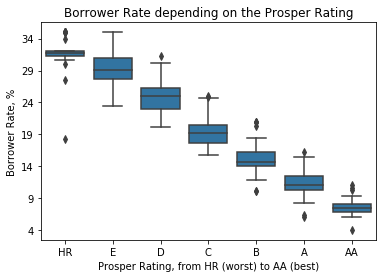

In [61]:
# plot the box plots of for the borrower rates depending on the Prosper Ratings
default_color = sb.color_palette()[0]
np.random.seed(2000)
sample_1000 = np.random.choice(loan_df_clean.shape[0], 1000, replace = False)
loan_df_subset1000 = loan_df_clean.reindex(sample_1000)
tick_props = np.arange(0.04, 0.36, 0.05)
tick_names = ['{:0.0f}'.format(v*100) for v in tick_props]
plt.yticks(tick_props, tick_names)

sb.boxplot(data = loan_df_subset1000, x = 'ProsperRating (Alpha)', y = 'BorrowerRate', color = default_color);
plt.xlabel('Prosper Rating, from HR (worst) to AA (best)')
plt.ylabel('Borrower Rate, %')
plt.title('Borrower Rate depending on the Prosper Rating');

From the above plot it can be clearly seen that the Prosper Rating has an immediate effect on the Borrower Rate: the higher the Prosper Rating is, the lower the Borrower Rate is.

## Multivariate Exploration

In the Multivatiate Section, I investigated the relationships between several variables of interest to further investigate the insights identified in the univariate and bivariate sections and try to answer the following questions:

1) Which factors affected the high Borrower Rate above 31%?

2) How do the Debt-to-Income Ratio and the Borrower Rate affect the Loan Original Amount?

3) Did the Prosper Rating affect the Borrower Rate and the Loan Amount?


#### 1) Which factors affected the high Borrower Rate above 31%? 

In [74]:
# convert the Loan Origination Year into ordered type
year_dict = {'LoanOriginationYear': ['2009', '2010', '2011', '2012', '2013', '2014']}
type_to_ordered(year_dict)

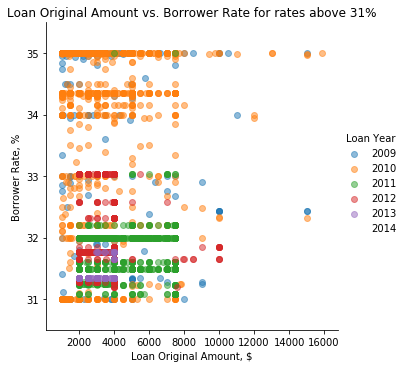

In [70]:
rate_31 = (loan_df_clean['BorrowerRate'] >= 0.31)
loan_df_31 = loan_df_clean.loc[rate_31,:]
loan_df_31.sample(5)

g = sb.FacetGrid(data = loan_df_31, hue = 'LoanOriginationYear', height = 5);
g.map(plt.scatter, 'LoanOriginalAmount', 'BorrowerRate', alpha = 0.5);
g.add_legend(title = 'Loan Year');
tick_props = np.arange(0.31, 0.36, 0.01)
tick_names = ['{:0.0f}'.format(v*100) for v in tick_props]
plt.yticks(tick_props, tick_names)
plt.ylim(0.305, 0.355);
plt.title('Loan Original Amount vs. Borrower Rate for rates above 31%')
plt.xlabel('Loan Original Amount, $')
plt.ylabel('Borrower Rate, %');

From the above plot we can clearly see that the high rates (above 31%) follow a certain pattern. There are clusters of particular rates, as for example at 35%, around 34.4%, 33%, above 32%, 32%, around 31.5% and 31%. And we also clearly see that the majority of these high rates are attributable to 2010 and 2011 years. These years experiences a financial downturn, which drove borrower interest rates up. Besides we clearly see that the high-rate loans all were below 16K. No loans for an amount larger than 16K have been provided at the rates as high as we see on this distribution. The overwelming majority of the high-rate loans were capped by the amount of 8K.

#### 2) How do the Debt-to-Income Ratio and the Borrower Rate affect the Loan Original Amount?

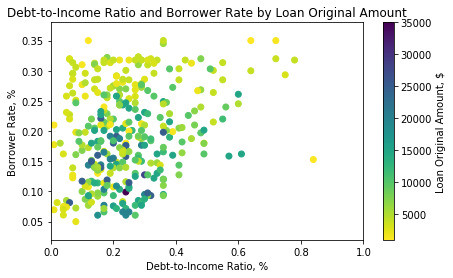

In [64]:
np.random.seed(2018)
sample = np.random.choice(loan_df_clean.shape[0], 500, replace = False)
loan_df_subset = loan_df_clean.reindex(sample)

# plotting the data
plt.figure(figsize = [7,4])
plt.scatter(data = loan_df_subset, x = 'DebtToIncomeRatio', y = 'BorrowerRate', c = 'LoanOriginalAmount',
            cmap = 'viridis_r')
plt.xlim(0, 1.0)
plt.title('Debt-to-Income Ratio and Borrower Rate by Loan Original Amount')
plt.xlabel('Debt-to-Income Ratio, %')
plt.ylabel('Borrower Rate, %')
plt.colorbar(label = 'Loan Original Amount, $');

From the above plot we can make the following inferences:

- the overwelming majority of loans were provided to borrowers with the Debt-to-Income Ratio of below 0.6. Overcredited borrowers with DIR above 0.4 are very rare in the dataset;

- the higher the Borrower Rate is, the lower the Loan Amount is;

- the higher the Debt-to-Income Ratio is, the lower the Loan Amount is.

The larger loan amounts were provided at lower interest rates and to borrowers with the Debt-to-Income Ratio under 0.4.

In [65]:
# create a subset of defaulted loans
defaulted_loans = (loan_df_clean.LoanStatus == 'Defaulted')
loan_df_defaulted = loan_df_clean.loc[defaulted_loans]

#### Do the lenders know beforehand that a borrower will not pay out the loan?

Borrower Rate for the loans with the statuses `Current`, `Completed` and `Defaulted` by Income Range.

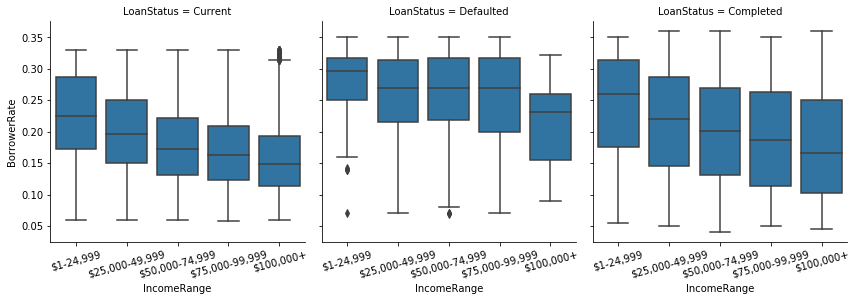

In [66]:
loan_df_status_2 = loan_df_clean[(loan_df_clean['LoanStatus']=='Defaulted') | (loan_df_clean['LoanStatus']=='Current') | (loan_df_clean['LoanStatus']=='Completed')].copy()
loan_df_status_2['LoanStatus'] = loan_df_status_2['LoanStatus'].astype(str)
g = sb.FacetGrid(loan_df_status_2, col = 'LoanStatus', height = 4)
g.map(sb.boxplot, 'IncomeRange', 'BorrowerRate', order = ['$1-24,999', '$25,000-49,999', '$50,000-74,999', 
                                '$75,000-99,999', '$100,000+']);
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

For the loans with the Loan Status of `Current` and `Completed`, the Borrower Rate decreased as the Income Range increased. For the `Defaulted` loans, however, the Borrower Rate remained on the same high level, except for the most upper Income Range. We already saw that the high rate was characteristic of the borrowers with lower Prosper Ratings. From these plots we see that the defaulted loans tend to have higher Borrower Rates, which confirms that the lenders know if a borrower is likely not to return the loan.

#### How are the Borrower Rate and the Loan Original Amount distributed by Prosper Ratings?

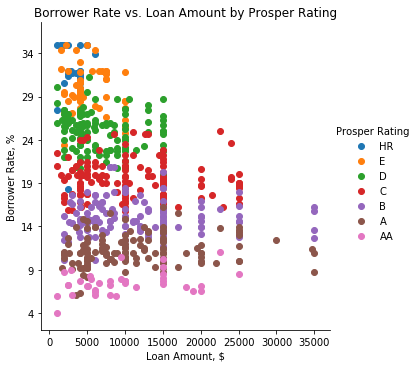

In [73]:
g = sb.FacetGrid(data = loan_df_subset1000, hue = 'ProsperRating (Alpha)', height = 5);
g.map(plt.scatter, 'LoanOriginalAmount', 'BorrowerRate');
tick_props = np.arange(0.04, 0.36, 0.05)
tick_names = ['{:0.0f}'.format(v*100) for v in tick_props]
plt.yticks(tick_props, tick_names)
plt.xlabel('Loan Amount, $')
plt.ylabel('Borrower Rate, %')
plt.title('Borrower Rate vs. Loan Amount by Prosper Rating')
g.add_legend(title = 'Prosper Rating');

This distribution clearly shows that the higher the Prosper Rating of a borrower is, the lower the Borrower Rate is. As for the Loan Amount, we see that the Loan Amount increases as the Prosper Rating increases and certain thresholds in the Loan Amount may be observed for particular Prosper Ratings, for example, 10K for E-borrowers, 15K for D-, C- and B-borrowers and the largest threshold for A- and AA-borrowers. And borrowers with the best Prosper Rating (AA) tend not to borrow large amounts. Way to go to keep their high ratings!

Based on my analysis of the Prosper loan dataset, I can conclude that all the following parameters influenced the Borrower Rate: 
- Loan Amount 
- Prosper Rating
- Income Range 
- Debt-to-Income Ratio.

Most vividly, the Borrower Rate was affected by the Prosper Rating.

The most interesting insights identified include: 

In the subset of Borrower Rates above 31%, there are clusters of rates at particular thresholds. The majority of these high rates are attributable to 2010 and 2011 years. The overwelming majority of the high-rate loans were capped by the amount of 8K.

The overwelming majority of loans were provided to borrowers with the Debt-to-Income Ratio of below 0.4. The higher the Debt-to-Income Ratio is, the lower the Loan Amount is. The larger loan amounts were provided at lower interest rates and to borrowers with the Debt-to-Income Ratio under 0.4.

The higher the Prosper Rating of a borrower is, the lower the Borrower Rate is. The Loan Amount increases as the Prosper Rating increases and certain thresholds in the Loan Amount may be observed for particular Prosper Ratings. And borrowers with the best Prosper Rating (AA) tend not to borrow large amounts. Way to go to keep their ratings high!

